In [1]:
from modules import *
from sim import save_fig

from colossus.cosmology import cosmology
from colossus.lss import peaks
cosmo = cosmology.setCosmology('planck18');


In [2]:
def calc_M_halo_crit(z, Sigma_crit=3e3*const.M_sol/const.pc**2, gal_to_halo=0.1):
    '''
    Critical halo mass for FFB.
    
    Args
    Sigma_crit: Critical surface density for FFB.
    '''
    Sigma_crit_comoving = Sigma_crit / (1 + z)**2
    rho_m = cosmo.rho_m(z) * (const.M_sol * cosmo.h**2 / const.kpc**3)
    R_gal = gal_to_halo * (3/(4*np.pi) / rho_m)**(1/3)
    dm_to_b = (cosmo.Om0 - cosmo.Ob0) / cosmo.Ob0
    M_halo_crit = (Sigma_crit_comoving * np.pi * R_gal**2 * dm_to_b)**3
    return M_halo_crit


In [87]:
def halo_to_stellar_mass(M_halo, z=0.):
    '''
    Halo mass as a function of stellar mass and redshift.
    
    From Girelli+2020 (https://arxiv.org/pdf/2001.02230.pdf).
    
    Args
    M_halo: halo mass in solar masses
    z: redshift
    
    Return
    M_stellar: stellar mass in solar masses
    '''
    B, mu, C, nu, D, eta, F, E = 11.83, 0.18, 0.047, -0.40, 0.728, -0.16, 0.052, 0.92
    
    M_A = 10**(B + z * mu)
    A = C * (1 + z)**mu
    gamma = D * (1 + z)**eta
    beta = F * z + E
    
    M_stellar = M_halo * 2 * A * ( (M_halo / M_A)**(-beta) + (M_halo / M_A)**gamma )**(-1)
    
    return M_stellar


def stellar_to_halo_mass(M_stellar, z=0.):
    '''
    Stellar mass as a function of halo mass and redshift.
    
    Args
    M_stellar: stellar mass in solar masses
    z: redshift
    
    Return
    M_stellar: stellar mass in solar masses
    '''
    assert M_stellar.shape == z.shape, "Stellar mass and redshift arrays must have the same shape."
    
    M_halo = np.zeros_like(M_stellar)
    
    for i, M_stellar_item in enumerate(M_stellar):
        M_halo[i] = fsolve(lambda M_halo: halo_to_stellar_mass(M_halo, z[i]) - M_stellar_item, 1e11)
    
    return M_halo


In [88]:
# Melia+2023 (https://arxiv.org/pdf/2302.10103.pdf)

JWST_names = [
    "S5-z17-1",
    "CEERS-93316",
    "S5-z12-1",
    "WHL0137-5021",
    "WHL0137-5124",
    "GLASS-z13",
    "GLASS-z12-1",
    "Maisie’s Galaxy",
    "GN-z11",
    "GLASS-z11",
    "WHL0137-3407",
    "WHL0137-5347",
    "WHL0137-5330"
]

JWST_z = np.array([16.66, 16.4, 13.72, 12.8, 12.8, 12.4, 12.22, 11.8, 11.09, 10.6, 10.5, 10.2, 10.0])
JWST_zp = np.array([1.86, 0.1, 0.86, 1.1, 1.9, 0, 0.04, 0.2, 0.08, 0, 1.0, 0.9, 1.1])
JWST_zm = np.array([0.34, 0.1, 1.92, 12.5, 12.4, 0, 0.11, 0.3, 0.12, 0, 10.5, 9.7, 7.9])

JWST_logM_stellar = np.array([8.8, 9.0, 8.1, 8.53, 8.65, 9.0, 8.6, 8.5, 9.0, 9.4, 8.78, 9.01, 8.77])
JWST_logMp_stellar = np.array([0.8, 0.4, 1.3, 0.18, 0.20, 0.3, 0.8, 0.29, 0, 0, 0.17, 0.21, 0.15])
JWST_logMm_stellar = np.array([0.5, 0.5, 0.3, 0.32, 0.30, 0.4, 0.4, 0.44, 0, 0, 0.33, 0.37, 0.26])

JWST_M = stellar_to_halo_mass(10**JWST_logM, JWST_z)
JWST_Mp = stellar_to_halo_mass(10**(JWST_logM + JWST_logMp), JWST_z) - JWST_M
JWST_Mm = JWST_M - stellar_to_halo_mass(10**(JWST_logM - JWST_logMm), JWST_z)


Saved figure as 'halos-102720231643.png'


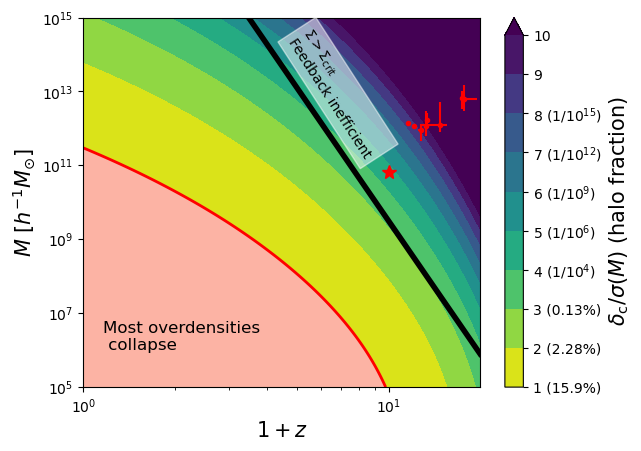

In [89]:
zp1 = np.logspace(0, 1.3, 300)
M = np.logspace(5, 15, 300)
z_grid, M_grid = np.meshgrid(zp1 - 1, M, indexing='ij')
nu = peaks.peakHeight(M_grid, z_grid)

im = plt.contourf(zp1, M, nu, levels=np.arange(1, 11, 1), cmap='viridis_r', extend='max')
plt.contour(zp1, M, nu, levels=[1], colors='red', linewidths=2)
plt.contourf(zp1, M, nu, levels=np.arange(0, 2, 1), cmap='Reds', alpha=0.5)
plt.annotate("Most overdensities\n collapse", xy=(0.05, 0.1), xycoords='axes fraction', fontsize=12)

M_halo_crit = calc_M_halo_crit(zp1 - 1) / (const.M_sol / cosmo.h)
plt.plot(zp1, M_halo_crit, color='black', lw=4)
plt.annotate(r"$\Sigma > \Sigma_{\rm crit}$" + "\n" + "Feedback inefficient", xy=(0.51, 0.62), xycoords='axes fraction', rotation=-57, backgroundcolor=(1, 1, 1, 0.5))

cond = (JWST_zp + JWST_zm) < 4
plt.errorbar(JWST_z[cond] + 1, JWST_M[cond] * cosmo.h, marker='.', linestyle='', color='red', yerr=(JWST_Mm[cond], JWST_Mp[cond]), xerr=(JWST_zm[cond], JWST_zp[cond]))
plt.plot(10, 1e11 * cosmo.h, marker='*', color='red', ms=10)

sigma_frac = (1 - erf(np.arange(1, 11)/np.sqrt(2))) / 2
tick_labels = ["1 (15.9%)", "2 (2.28%)", "3 (0.13%)", r"4 (1/$10^4$)", r"5 (1/$10^6$)", r"6 (1/$10^9$)", r"7 (1/$10^{12}$)", r"8 (1/$10^{15}$)", "9", "10"]

cbar = plt.colorbar(im, ticks=np.arange(1, 11))
cbar.ax.set_yticklabels(tick_labels)
cbar.set_label(label=r'$\delta_{\rm c} / \sigma(M)$ (halo fraction)', size=15)

plt.xscale('log')
plt.yscale('log')

plt.xlim(10**0, 10**1.3)
plt.ylim(1e5,1e15)

plt.xlabel(r'$1 + z$', fontsize=15)
plt.ylabel(r'$M$ [$h^{-1} M_{\odot}$]', fontsize=15)

#plt.plot(10, 1e11 * cosmo.h, 'o', color='red')

#save_fig("halos")
